In [49]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."));

In [50]:
using JuMP
using BARON
using CouenneNL
using LinearAlgebra
using Parameters
using MINLPTrajOpt

In [51]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = false

true

The optimizer is clearly exploiting numerical issues due to the primitive integration scheme, injecting energy by searching for instability.

TODO:

* Running state cost
* AxisArrays for sanity
* Better discretization of the continuous time dynamics
* Think about better integration schemes
  * Central differencing for accelerations
  * Semi-implicit Euler
  * Energy flow constraints
  * Variable time steps
* Keep track of total energy
* Compare to COUENNE

In [52]:
solver = BaronSolver(threads=Sys.CPU_THREADS)
# solver = CouenneNLSolver()
parameters = PendulumParameters()
τmax = parameters.m * parameters.g * parameters.l * 0.7
θ0 = 0.1
θd0 = 0.0
T = 8.0
N = 40
Δt = T / N
problem = PendulumSwingUpProblem(parameters, (θ0, θd0), solver;
    τmax = τmax, Δt=Δt, N=N);

In [53]:
status = solve(problem.model)
@assert status == :Optimal
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "pendulum", "run$i"); isdir(datadir))
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(problem.model.internalModel.options[:SumName], joinpath(datadir, "sum.lst"))
end

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  2015.84311612     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  1952.22025432   

"/home/twan/code/julia-projects/MINLPTrajOpt/src/../data/pendulum/run1/sum.lst"

In [54]:
include(joinpath(rootdir, "extras", "plotting.jl"));

In [55]:
t = range(0.0, stop=T, length=N)
Δθ = atan.(getvalue.(problem.sΔθ) ./ getvalue.(problem.cΔθ))
θ = θ0 .+ cumsum(Δθ)
τ = getvalue.(problem.τ)
θdd = getvalue.(problem.θdd);

In [56]:
if save_data
    open(joinpath(datadir, "settings.txt"), write=true) do io
        println(io, "N = $N")
        println(io, "θ0 = $θ0")
        println(io, "θd0 = $θd0")
        println(io, "solver = $solver")
        println(io, "status = $status")
        println(io, "solvetime = $(getsolvetime(problem.model))")
        println(io)
    end
end

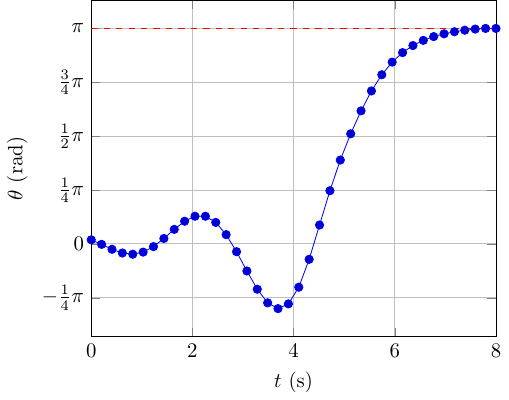

In [57]:
p = timeplot(t, θ; ylabel=L"$\theta$ (rad)")
push!(p, @pgf HLine({dashed, red, thick}, Float64(π)))
piticks!(p, 1//4; axis=:y)
save_data && pgfsave(joinpath(datadir, "theta.pdf"), p)
p

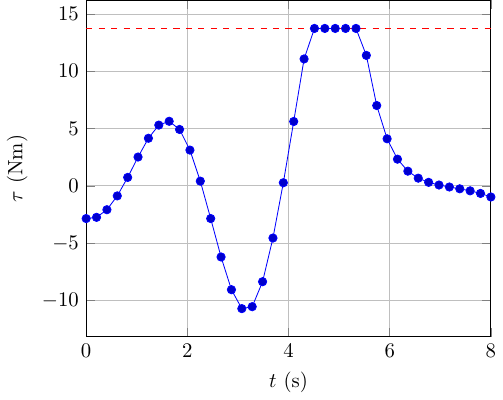

In [58]:
p = timeplot(t, τ; ylabel=L"$\tau$ (Nm)")
push!(p, @pgf HLine({dashed, red, thick}, τmax))
push!(p, @pgf HLine({dashed, red, thick}, -τmax))
save_data && pgfsave(joinpath(datadir, "tau.pdf"), p)
p

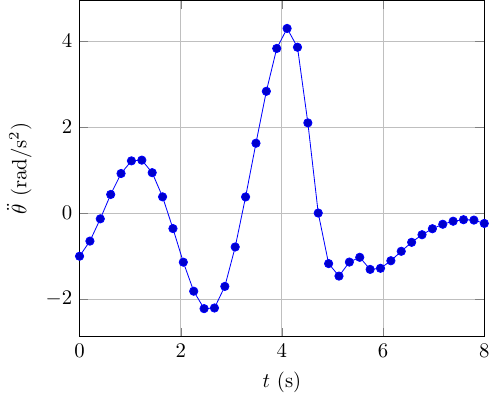

In [59]:
p = timeplot(t, θdd; ylabel=L"$\ddot{\theta}$ (rad/$\textrm{s}^2$)")
save_data && pgfsave(joinpath(datadir, "thetadd.pdf"), p)
p